# MNIST Digit Classification

In [76]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms

%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


## Downloading the dataset


In [77]:
dataset=MNIST(root='data/',train=True,
              download=True, 
              transform=ToTensor())

## Looking at the dataset

image.shape: torch.Size([1, 28, 28])
Label: 5


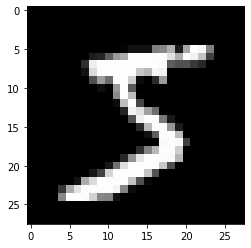

In [78]:
image,label=dataset[0]
print('image.shape:',image.shape)
plt.imshow(image.permute(1,2,0),cmap='gray')
print('Label:',label)

## Dividing training set to validation set

In [79]:
val_size=10000
train_size=len(dataset)-val_size

train_ds,val_ds=random_split(dataset, [train_size,val_size])
len(train_ds),len(val_ds)


(50000, 10000)

## Creating a batch size

In [80]:
batch_size=50

## Loading dataset using Dataloader

In [81]:
train_loader=DataLoader(train_ds, batch_size,shuffle=True, num_workers=4,pin_memory=True)
val_loader=DataLoader(val_ds, batch_size*2,num_workers=4,pin_memory=True)

## Visualizing a batch of data

image.shape:  torch.Size([50, 1, 28, 28])


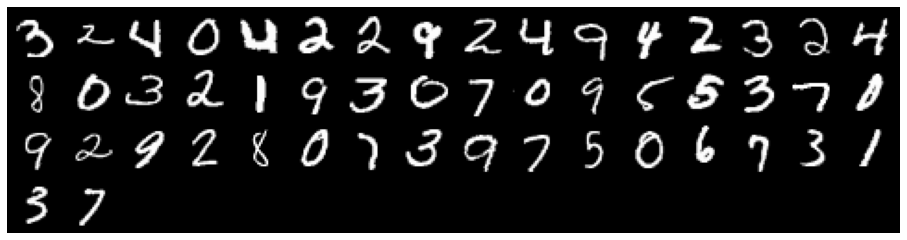

In [82]:
for images,_ in train_loader:
    print('image.shape: ',images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
    break

## Making the model

In [83]:
class MnistModel(nn.Module):
    # feedforward neural network with 2 hidden layer
    def __init__(self,in_size,hidden_size,out_size):
        super().__init__()
        #hidden layer 1
        self.linear1=nn.Linear(in_size,hidden_size)
        
        #hidden layer2
        self.linear2=nn.Linear(hidden_size,hidden_size)
        
        #output layer
        self.linear3=nn.Linear(hidden_size,out_size)
        
       
       
    def forward(self, xb):
        
        #flatten the image tensors
        xb=xb.view(xb.size(0),-1)
        # passing through hidden layer1
        out_layer1=self.linear1(xb)
         
            
            
        # Applying batch normalisation to layer 1
        nn.BatchNorm1d(hidden_size)
        #applying relu to layer 1
        relu_out_layer1=F.relu(out_layer1)
    
        
        
        
        # passing through hidden layer 2
        out_layer2=self.linear2(relu_out_layer1)
        
        
        #Apllying batch normalisation to layer2
        nn.BatchNorm1d(hidden_size)
        # Apllying relu to layer2
        relu_out_layer2=F.relu(out_layer2)
      
        
        
        #get prediction using output layer
        out=self.linear3(relu_out_layer2)
        return out
    
    def training_step(self,batch):
        images,labels=batch
        out= self(images)
        loss= F.cross_entropy(out,labels)#calculate loss
        acc=accuracy(out,labels)
        return {'training_loss':loss,'training_acc':acc}
    
    def validation_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=F.cross_entropy(out,labels)
        acc=accuracy(out,labels)
        return {'val_loss':loss, 'val_acc':acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses=[x['val_loss']for x in outputs]
        epoch_loss=torch.stack(batch_losses).mean()#combine losses
        batch_accs=[x['val_acc']for x in outputs]
        epoch_acc=torch.stack(batch_accs).mean()
        return{'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
    
    def training_epoch_end(self,outputs):
        batch_losses=[x['training_loss']for x in outputs]
        epoch_loss=torch.stack(batch_losses).mean()#combine losses
        batch_accs=[x['training_acc']for x in outputs]
        epoch_acc=torch.stack(batch_accs).mean()
        return{'training_loss':epoch_loss.item(),'training_acc':epoch_acc.item()}
    
    def v_epoch_end_printformat(self,epoch,result):
        print("Epoch [{}], val_loss: {:.4f},val_acc:{:.4f}".format(epoch,result['val_loss'],result['val_acc']))
    def t_epoch_end_printformat(self,epoch,result):
        print("Epoch [{}], training_loss: {:.4f},training_acc:{:.4f}".format(epoch,result['training_loss'],result['training_acc']))

In [84]:
def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

## Giving values to the model

In [85]:
input_size=784
hidden_size=500
num_classes=10


In [86]:
model=MnistModel(input_size,hidden_size=500, out_size=num_classes)

In [87]:
for t in model.parameters():  # seeing parameters of our model
    print(t.shape)

torch.Size([500, 784])
torch.Size([500])
torch.Size([500, 500])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])


## Using GPU

In [88]:
torch.cuda.is_available()

True

In [89]:
# code that helps to use gpu when available or else use cpu
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [90]:

device=get_default_device()
device

device(type='cuda')

In [91]:
# Defining a function which can move data and model to chosen device

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device)for x in data]
    return data.to(device,non_blocking=True)


In [92]:
# checkin the above function
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([50, 1, 28, 28])
cuda:0


In [93]:
# making a devicedataLoader class to wrap dataloader and move batches
#to slected device
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [94]:
train_loader= DeviceDataLoader(train_loader,device)
val_loader= DeviceDataLoader(val_loader,device)


In [95]:
# checking above function
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([4, 4, 8, 4, 0, 9, 7, 6, 4, 0, 6, 4, 4, 7, 2, 0, 6, 9, 2, 8, 9, 5, 3, 0,
        9, 5, 1, 6, 8, 6, 3, 5, 4, 0, 5, 5, 4, 2, 7, 9, 3, 2, 7, 5, 2, 4, 3, 5,
        3, 0, 3, 8, 4, 8, 3, 1, 7, 7, 5, 1, 4, 4, 8, 7, 6, 2, 6, 8, 9, 8, 3, 6,
        6, 1, 2, 3, 4, 8, 1, 7, 7, 2, 6, 4, 8, 0, 6, 8, 7, 0, 9, 9, 4, 2, 7, 1,
        0, 0, 4, 1], device='cuda:0')


## Functions used to Training the model

In [96]:
def evaluate(model,val_loader):
    # evaluate model performance om validation set
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)




def fit_noRegularisation(epochs, lr , model, train_loader, val_loader,opt_func=torch.optim.SGD):
    # training the model uing gradient descent
    validation_history=[]
    training_history=[]
    optimiser=opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        # Training phase
        b=[]
        for batch in train_loader:
            a= model.training_step(batch)
            #print(a.keys)
            loss=a['training_loss']
            acc=a['training_acc']
            b.append(a)
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()
        d=model.training_epoch_end(b)
        model.t_epoch_end_printformat(epoch,d)
        training_history.append(d)
        #Validation phase
        result=evaluate(model,val_loader)
        model.v_epoch_end_printformat(epoch,result)
        validation_history.append(result)
    return validation_history,training_history




## Moving data and model to same device(CPU or GPU)

In [97]:
model=MnistModel(input_size,hidden_size=hidden_size,out_size=num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=500, bias=True)
  (linear3): Linear(in_features=500, out_features=10, bias=True)
)

## Training the model

In [98]:
#loss and accuracy with initial parameters
history=[evaluate(model,val_loader)]
history


[{'val_loss': 2.305295467376709, 'val_acc': 0.09419999271631241}]

In [99]:
validation_history=[]
training_history=[]

a,b= fit_noRegularisation(250, 0.01, model, train_loader, val_loader)
validation_history+=a
training_history+=b

Epoch [0], training_loss: 1.5125,training_acc:0.6573
Epoch [0], val_loss: 0.6450,val_acc:0.8393
Epoch [1], training_loss: 0.4803,training_acc:0.8725
Epoch [1], val_loss: 0.4064,val_acc:0.8810
Epoch [2], training_loss: 0.3624,training_acc:0.8974
Epoch [2], val_loss: 0.3473,val_acc:0.9005
Epoch [3], training_loss: 0.3191,training_acc:0.9087
Epoch [3], val_loss: 0.3166,val_acc:0.9071
Epoch [4], training_loss: 0.2921,training_acc:0.9159
Epoch [4], val_loss: 0.2934,val_acc:0.9132
Epoch [5], training_loss: 0.2709,training_acc:0.9225
Epoch [5], val_loss: 0.2731,val_acc:0.9210
Epoch [6], training_loss: 0.2523,training_acc:0.9273
Epoch [6], val_loss: 0.2558,val_acc:0.9273
Epoch [7], training_loss: 0.2360,training_acc:0.9324
Epoch [7], val_loss: 0.2397,val_acc:0.9308
Epoch [8], training_loss: 0.2211,training_acc:0.9372
Epoch [8], val_loss: 0.2288,val_acc:0.9341
Epoch [9], training_loss: 0.2069,training_acc:0.9412
Epoch [9], val_loss: 0.2148,val_acc:0.9386
Epoch [10], training_loss: 0.1941,traini

Epoch [84], training_loss: 0.0114,training_acc:0.9989
Epoch [84], val_loss: 0.0786,val_acc:0.9780
Epoch [85], training_loss: 0.0110,training_acc:0.9990
Epoch [85], val_loss: 0.0797,val_acc:0.9780
Epoch [86], training_loss: 0.0107,training_acc:0.9990
Epoch [86], val_loss: 0.0795,val_acc:0.9789
Epoch [87], training_loss: 0.0104,training_acc:0.9992
Epoch [87], val_loss: 0.0800,val_acc:0.9782
Epoch [88], training_loss: 0.0101,training_acc:0.9991
Epoch [88], val_loss: 0.0804,val_acc:0.9779
Epoch [89], training_loss: 0.0099,training_acc:0.9992
Epoch [89], val_loss: 0.0800,val_acc:0.9778
Epoch [90], training_loss: 0.0095,training_acc:0.9994
Epoch [90], val_loss: 0.0822,val_acc:0.9783
Epoch [91], training_loss: 0.0093,training_acc:0.9992
Epoch [91], val_loss: 0.0797,val_acc:0.9786
Epoch [92], training_loss: 0.0091,training_acc:0.9994
Epoch [92], val_loss: 0.0807,val_acc:0.9786
Epoch [93], training_loss: 0.0088,training_acc:0.9994
Epoch [93], val_loss: 0.0802,val_acc:0.9786
Epoch [94], training

Epoch [166], val_loss: 0.0894,val_acc:0.9796
Epoch [167], training_loss: 0.0022,training_acc:1.0000
Epoch [167], val_loss: 0.0887,val_acc:0.9792
Epoch [168], training_loss: 0.0022,training_acc:1.0000
Epoch [168], val_loss: 0.0895,val_acc:0.9797
Epoch [169], training_loss: 0.0021,training_acc:1.0000
Epoch [169], val_loss: 0.0893,val_acc:0.9791
Epoch [170], training_loss: 0.0021,training_acc:1.0000
Epoch [170], val_loss: 0.0897,val_acc:0.9794
Epoch [171], training_loss: 0.0021,training_acc:1.0000
Epoch [171], val_loss: 0.0894,val_acc:0.9793
Epoch [172], training_loss: 0.0021,training_acc:1.0000
Epoch [172], val_loss: 0.0895,val_acc:0.9790
Epoch [173], training_loss: 0.0020,training_acc:1.0000
Epoch [173], val_loss: 0.0900,val_acc:0.9795
Epoch [174], training_loss: 0.0020,training_acc:1.0000
Epoch [174], val_loss: 0.0901,val_acc:0.9793
Epoch [175], training_loss: 0.0020,training_acc:1.0000
Epoch [175], val_loss: 0.0896,val_acc:0.9790
Epoch [176], training_loss: 0.0020,training_acc:1.0000


Epoch [248], val_loss: 0.0964,val_acc:0.9796
Epoch [249], training_loss: 0.0010,training_acc:1.0000
Epoch [249], val_loss: 0.0959,val_acc:0.9795


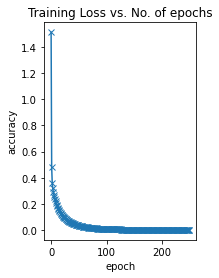

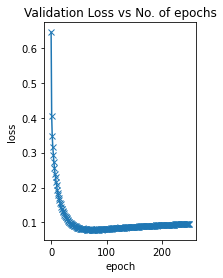

In [100]:
training_loss = [x['training_loss'] for x in training_history]
plt.subplot(1,2,1)
plt.plot(training_loss, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training Loss vs. No. of epochs');
plt.show()
validation_losses=[x['val_loss'] for x in validation_history]
plt.subplot(1,2,2)
plt.plot(validation_losses,'-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Validation Loss vs No. of epochs')
plt.show()

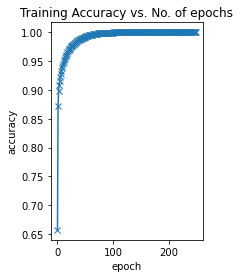

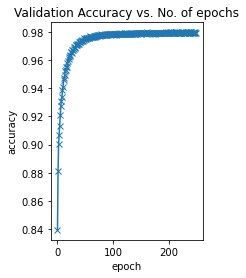

In [101]:
training_accuracies = [x['training_acc'] for x in training_history]
plt.subplot(1,2,1)
plt.plot(training_accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training Accuracy vs. No. of epochs');
plt.show()
validation_accuracies = [x['val_acc'] for x in validation_history]
plt.subplot(1,2,2)
plt.plot(validation_accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Validation Accuracy vs. No. of epochs');
plt.show()

## Testing with individual images

In [102]:
test_dataset=MNIST(root='data/',train=False,transform=ToTensor())

In [103]:
def predict_image(img,model):
    xb=to_device(img.unsqueeze(0),device)
    yb=model(xb)
    _,preds=torch.max(yb,dim=1)
    return preds[0].item()

In [104]:
len(test_dataset)

10000

Label: 7 ,predicted: 7


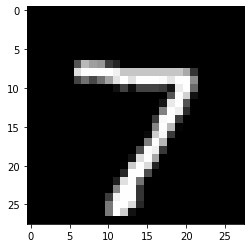

In [105]:
img,label= test_dataset[0]
plt.imshow(img[0],cmap='gray')
print('Label:',label,',predicted:',predict_image(img,model))

Label: 1 ,predicted: 1


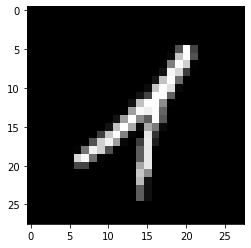

In [106]:
img,label= test_dataset[1868]
plt.imshow(img[0],cmap='gray')
print('Label:',label,',predicted:',predict_image(img,model))

## Loss and accuracy on test dataset with no regulariation

In [107]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
test_loss=result['val_loss']
test_acc=result['val_acc']
print('test_loss:',test_loss)
print('test_acc:' ,test_acc)

test_loss: 0.07664334028959274
test_acc: 0.9814453125


# For L2 Regularisation

In [108]:
def fit_L2_Regularisation(epochs, lr , model, train_loader, val_loader,opt_func=torch.optim.SGD):
    # training the model uing gradient descent
    validation_history=[]
    training_history=[]
    optimiser=opt_func(model.parameters(), lr,weight_decay=0.001)
    
    for epoch in range(epochs):
        # Training phase
        b=[]
        for batch in train_loader:
            a= model.training_step(batch)
            #print(a.keys)
            loss=a['training_loss']
            acc=a['training_acc']
            b.append(a)
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()
        d=model.training_epoch_end(b)
        model.t_epoch_end_printformat(epoch,d)
        training_history.append(d)
        #Validation phase
        result=evaluate(model,val_loader)
        model.v_epoch_end_printformat(epoch,result)
        validation_history.append(result)
    return validation_history,training_history

In [109]:
model_L2_Regularisation=MnistModel(input_size,hidden_size=hidden_size,out_size=num_classes)
to_device(model_L2_Regularisation,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=500, bias=True)
  (linear3): Linear(in_features=500, out_features=10, bias=True)
)

In [110]:
validation_history=[]
training_history=[]

c,d= fit_L2_Regularisation(250, 0.01, model_L2_Regularisation, train_loader, val_loader)
validation_history+=c
training_history+=d

Epoch [0], training_loss: 1.5171,training_acc:0.6427
Epoch [0], val_loss: 0.6504,val_acc:0.8392
Epoch [1], training_loss: 0.4838,training_acc:0.8725
Epoch [1], val_loss: 0.4084,val_acc:0.8849
Epoch [2], training_loss: 0.3663,training_acc:0.8982
Epoch [2], val_loss: 0.3479,val_acc:0.8993
Epoch [3], training_loss: 0.3233,training_acc:0.9087
Epoch [3], val_loss: 0.3189,val_acc:0.9066
Epoch [4], training_loss: 0.2965,training_acc:0.9163
Epoch [4], val_loss: 0.2957,val_acc:0.9141
Epoch [5], training_loss: 0.2754,training_acc:0.9221
Epoch [5], val_loss: 0.2801,val_acc:0.9204
Epoch [6], training_loss: 0.2577,training_acc:0.9267
Epoch [6], val_loss: 0.2628,val_acc:0.9251
Epoch [7], training_loss: 0.2412,training_acc:0.9314
Epoch [7], val_loss: 0.2477,val_acc:0.9280
Epoch [8], training_loss: 0.2267,training_acc:0.9361
Epoch [8], val_loss: 0.2347,val_acc:0.9333
Epoch [9], training_loss: 0.2136,training_acc:0.9398
Epoch [9], val_loss: 0.2236,val_acc:0.9377
Epoch [10], training_loss: 0.2015,traini

Epoch [84], training_loss: 0.0370,training_acc:0.9930
Epoch [84], val_loss: 0.0802,val_acc:0.9777
Epoch [85], training_loss: 0.0367,training_acc:0.9933
Epoch [85], val_loss: 0.0803,val_acc:0.9773
Epoch [86], training_loss: 0.0364,training_acc:0.9932
Epoch [86], val_loss: 0.0798,val_acc:0.9770
Epoch [87], training_loss: 0.0362,training_acc:0.9934
Epoch [87], val_loss: 0.0797,val_acc:0.9768
Epoch [88], training_loss: 0.0358,training_acc:0.9934
Epoch [88], val_loss: 0.0796,val_acc:0.9773
Epoch [89], training_loss: 0.0356,training_acc:0.9935
Epoch [89], val_loss: 0.0787,val_acc:0.9778
Epoch [90], training_loss: 0.0355,training_acc:0.9937
Epoch [90], val_loss: 0.0803,val_acc:0.9770
Epoch [91], training_loss: 0.0352,training_acc:0.9936
Epoch [91], val_loss: 0.0791,val_acc:0.9776
Epoch [92], training_loss: 0.0349,training_acc:0.9936
Epoch [92], val_loss: 0.0789,val_acc:0.9778
Epoch [93], training_loss: 0.0347,training_acc:0.9941
Epoch [93], val_loss: 0.0789,val_acc:0.9774
Epoch [94], training

Epoch [166], val_loss: 0.0733,val_acc:0.9791
Epoch [167], training_loss: 0.0270,training_acc:0.9969
Epoch [167], val_loss: 0.0734,val_acc:0.9784
Epoch [168], training_loss: 0.0271,training_acc:0.9966
Epoch [168], val_loss: 0.0738,val_acc:0.9785
Epoch [169], training_loss: 0.0271,training_acc:0.9967
Epoch [169], val_loss: 0.0730,val_acc:0.9787
Epoch [170], training_loss: 0.0270,training_acc:0.9968
Epoch [170], val_loss: 0.0736,val_acc:0.9792
Epoch [171], training_loss: 0.0269,training_acc:0.9968
Epoch [171], val_loss: 0.0745,val_acc:0.9792
Epoch [172], training_loss: 0.0269,training_acc:0.9965
Epoch [172], val_loss: 0.0740,val_acc:0.9792
Epoch [173], training_loss: 0.0269,training_acc:0.9967
Epoch [173], val_loss: 0.0736,val_acc:0.9789
Epoch [174], training_loss: 0.0269,training_acc:0.9966
Epoch [174], val_loss: 0.0737,val_acc:0.9793
Epoch [175], training_loss: 0.0268,training_acc:0.9968
Epoch [175], val_loss: 0.0734,val_acc:0.9794
Epoch [176], training_loss: 0.0267,training_acc:0.9971


Epoch [248], val_loss: 0.0728,val_acc:0.9802
Epoch [249], training_loss: 0.0251,training_acc:0.9974
Epoch [249], val_loss: 0.0729,val_acc:0.9794


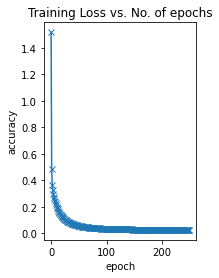

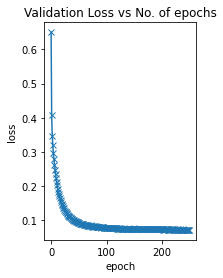

In [111]:
training_loss = [x['training_loss'] for x in training_history]
plt.subplot(1,2,1)
plt.plot(training_loss, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training Loss vs. No. of epochs')
plt.show()
validation_losses=[x['val_loss'] for x in validation_history]
plt.subplot(1,2,2)
plt.plot(validation_losses,'-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Validation Loss vs No. of epochs')
plt.show()

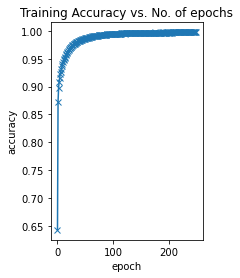

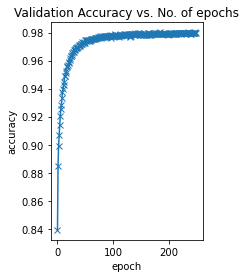

In [112]:
training_accuracies = [x['training_acc'] for x in training_history]
plt.subplot(1,2,1)
plt.plot(training_accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training Accuracy vs. No. of epochs');
plt.show()
validation_accuracies = [x['val_acc'] for x in validation_history]
plt.subplot(1,2,2)
plt.plot(validation_accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Validation Accuracy vs. No. of epochs');
plt.show()

In [113]:
def predict_image(img,model_L2_Regularisation):
    xb=to_device(img.unsqueeze(0),device)
    yb=model_L2_Regularisation(xb)
    _,preds=torch.max(yb,dim=1)
    return preds[0].item()

Label: 1 ,predicted: 1


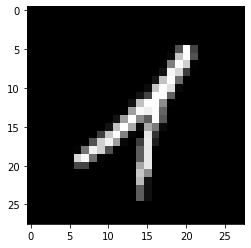

In [114]:
img,label= test_dataset[1868]
plt.imshow(img[0],cmap='gray')
print('Label:',label,',predicted:',predict_image(img,model))

## Loss and accuracy on test dataset with L2 Regularisation

In [115]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model_L2_Regularisation, test_loader)

test_loss=result['val_loss']
test_acc=result['val_acc']
print('test_loss:',test_loss)
print('test_acc:' ,test_acc)

test_loss: 0.06012877821922302
test_acc: 0.982421875


# Dropout

In [116]:
class MnistModel_dropout(nn.Module):
    # feedforward neural network with 2 hidden layer
    def __init__(self,in_size,hidden_size,out_size):
        super().__init__()
        #hidden layer 1
        self.linear1=nn.Linear(in_size,hidden_size)
        
        #hidden layer2
        self.linear2=nn.Linear(hidden_size,hidden_size)
        
        #output layer
        self.linear3=nn.Linear(hidden_size,out_size)
        #dropout
        
        self.dropout=nn.Dropout(0.8)
       
    def forward(self, xb):
        
        #flatten the image tensors
        xb=xb.view(xb.size(0),-1)
        # passing through hidden layer1
        out_layer1=self.linear1(xb)
         
            
            
        # Applying batch normalisation to layer 1
        nn.BatchNorm1d(hidden_size)
        #applying relu to layer 1
        relu_out_layer1=F.relu(out_layer1)
       #Applying dropout if option given

        relu_out_layer1=self.dropout(relu_out_layer1)
        
        
        
        # passing through hidden layer 2
        out_layer2=self.linear2(relu_out_layer1)
        
        
        #Apllying batch normalisation to layer2
        nn.BatchNorm1d(hidden_size)
        # Apllying relu to layer2
        relu_out_layer2=F.relu(out_layer2)
        #Applying dropout if option given
        
        relu_out_layer2=F.relu(relu_out_layer2)
        
        
        #get prediction using output layer
        out=self.linear3(relu_out_layer2)
        return out
    
    def training_step(self,batch):
        images,labels=batch
        out= self(images)
        loss= F.cross_entropy(out,labels)#calculate loss
        acc=accuracy(out,labels)
        return {'training_loss':loss,'training_acc':acc}
    
    def validation_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=F.cross_entropy(out,labels)
        acc=accuracy(out,labels)
        return {'val_loss':loss, 'val_acc':acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses=[x['val_loss']for x in outputs]
        epoch_loss=torch.stack(batch_losses).mean()#combine losses
        batch_accs=[x['val_acc']for x in outputs]
        epoch_acc=torch.stack(batch_accs).mean()
        return{'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
    
    def training_epoch_end(self,outputs):
        batch_losses=[x['training_loss']for x in outputs]
        epoch_loss=torch.stack(batch_losses).mean()#combine losses
        batch_accs=[x['training_acc']for x in outputs]
        epoch_acc=torch.stack(batch_accs).mean()
        return{'training_loss':epoch_loss.item(),'training_acc':epoch_acc.item()}
    
    def v_epoch_end_printformat(self,epoch,result):
        print("Epoch [{}], val_loss: {:.4f},val_acc:{:.4f}".format(epoch,result['val_loss'],result['val_acc']))
    def t_epoch_end_printformat(self,epoch,result):
        print("Epoch [{}], training_loss: {:.4f},training_acc:{:.4f}".format(epoch,result['training_loss'],result['training_acc']))

In [117]:
input_size=784
hidden_size=500
num_classes=10

In [118]:
model_dropout=MnistModel_dropout(input_size,hidden_size=500, out_size=num_classes)

In [119]:
def evaluate(model,val_loader):
    # evaluate model performance om validation set
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)




def fit_dropout(epochs, lr , model, train_loader, val_loader,opt_func=torch.optim.SGD):
    # training the model uing gradient descent
    validation_history=[]
    training_history=[]
    optimiser=opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        # Training phase
        b=[]
        for batch in train_loader:
            a= model.training_step(batch)
            #print(a.keys)
            loss=a['training_loss']
            acc=a['training_acc']
            b.append(a)
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()
        d=model.training_epoch_end(b)
        model.t_epoch_end_printformat(epoch,d)
        training_history.append(d)
        #Validation phase
        result=evaluate(model,val_loader)
        model.v_epoch_end_printformat(epoch,result)
        validation_history.append(result)
    return validation_history,training_history




In [120]:
model_dropout=MnistModel_dropout(input_size,hidden_size=hidden_size,out_size=num_classes)
to_device(model_dropout,device)

MnistModel_dropout(
  (linear1): Linear(in_features=784, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=500, bias=True)
  (linear3): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)

In [121]:
validation_history=[]
training_history=[]

e,f= fit_dropout(250, 0.01, model_dropout, train_loader, val_loader)
validation_history+=e
training_history+=f

Epoch [0], training_loss: 1.8168,training_acc:0.4512
Epoch [0], val_loss: 1.0402,val_acc:0.6933
Epoch [1], training_loss: 0.7716,training_acc:0.7666
Epoch [1], val_loss: 0.6227,val_acc:0.8158
Epoch [2], training_loss: 0.5493,training_acc:0.8374
Epoch [2], val_loss: 0.5107,val_acc:0.8467
Epoch [3], training_loss: 0.4640,training_acc:0.8634
Epoch [3], val_loss: 0.4473,val_acc:0.8683
Epoch [4], training_loss: 0.4113,training_acc:0.8791
Epoch [4], val_loss: 0.4047,val_acc:0.8842
Epoch [5], training_loss: 0.3738,training_acc:0.8918
Epoch [5], val_loss: 0.3721,val_acc:0.8895
Epoch [6], training_loss: 0.3478,training_acc:0.8982
Epoch [6], val_loss: 0.3393,val_acc:0.8992
Epoch [7], training_loss: 0.3216,training_acc:0.9061
Epoch [7], val_loss: 0.3356,val_acc:0.9005
Epoch [8], training_loss: 0.3023,training_acc:0.9125
Epoch [8], val_loss: 0.3059,val_acc:0.9079
Epoch [9], training_loss: 0.2862,training_acc:0.9169
Epoch [9], val_loss: 0.2993,val_acc:0.9135
Epoch [10], training_loss: 0.2727,traini

Epoch [84], training_loss: 0.0853,training_acc:0.9741
Epoch [84], val_loss: 0.1406,val_acc:0.9588
Epoch [85], training_loss: 0.0831,training_acc:0.9736
Epoch [85], val_loss: 0.1417,val_acc:0.9594
Epoch [86], training_loss: 0.0836,training_acc:0.9741
Epoch [86], val_loss: 0.1426,val_acc:0.9570
Epoch [87], training_loss: 0.0833,training_acc:0.9742
Epoch [87], val_loss: 0.1453,val_acc:0.9590
Epoch [88], training_loss: 0.0825,training_acc:0.9748
Epoch [88], val_loss: 0.1490,val_acc:0.9602
Epoch [89], training_loss: 0.0823,training_acc:0.9740
Epoch [89], val_loss: 0.1456,val_acc:0.9591
Epoch [90], training_loss: 0.0818,training_acc:0.9746
Epoch [90], val_loss: 0.1414,val_acc:0.9586
Epoch [91], training_loss: 0.0810,training_acc:0.9745
Epoch [91], val_loss: 0.1478,val_acc:0.9606
Epoch [92], training_loss: 0.0824,training_acc:0.9743
Epoch [92], val_loss: 0.1457,val_acc:0.9592
Epoch [93], training_loss: 0.0805,training_acc:0.9748
Epoch [93], val_loss: 0.1515,val_acc:0.9566
Epoch [94], training

Epoch [166], val_loss: 0.1387,val_acc:0.9604
Epoch [167], training_loss: 0.0537,training_acc:0.9819
Epoch [167], val_loss: 0.1267,val_acc:0.9655
Epoch [168], training_loss: 0.0555,training_acc:0.9812
Epoch [168], val_loss: 0.1387,val_acc:0.9620
Epoch [169], training_loss: 0.0538,training_acc:0.9823
Epoch [169], val_loss: 0.1421,val_acc:0.9610
Epoch [170], training_loss: 0.0555,training_acc:0.9815
Epoch [170], val_loss: 0.1431,val_acc:0.9610
Epoch [171], training_loss: 0.0543,training_acc:0.9822
Epoch [171], val_loss: 0.1491,val_acc:0.9620
Epoch [172], training_loss: 0.0531,training_acc:0.9824
Epoch [172], val_loss: 0.1422,val_acc:0.9612
Epoch [173], training_loss: 0.0560,training_acc:0.9821
Epoch [173], val_loss: 0.1349,val_acc:0.9633
Epoch [174], training_loss: 0.0522,training_acc:0.9828
Epoch [174], val_loss: 0.1446,val_acc:0.9614
Epoch [175], training_loss: 0.0538,training_acc:0.9822
Epoch [175], val_loss: 0.1501,val_acc:0.9611
Epoch [176], training_loss: 0.0524,training_acc:0.9835


Epoch [248], val_loss: 0.1444,val_acc:0.9637
Epoch [249], training_loss: 0.0428,training_acc:0.9861
Epoch [249], val_loss: 0.1392,val_acc:0.9631


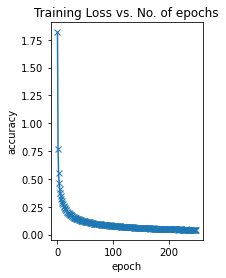

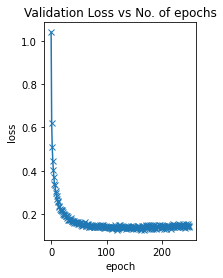

In [122]:
training_loss = [x['training_loss'] for x in training_history]
plt.subplot(1,2,1)
plt.plot(training_loss, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training Loss vs. No. of epochs')
plt.show()
validation_losses=[x['val_loss'] for x in validation_history]
plt.subplot(1,2,2)
plt.plot(validation_losses,'-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Validation Loss vs No. of epochs')
plt.show()

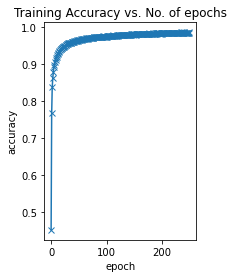

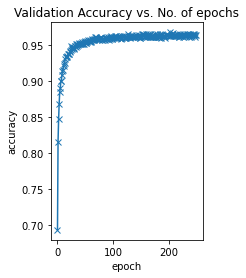

In [123]:
training_accuracies = [x['training_acc'] for x in training_history]
plt.subplot(1,2,1)
plt.plot(training_accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training Accuracy vs. No. of epochs');
plt.show()

validation_accuracies = [x['val_acc'] for x in validation_history]
plt.subplot(1,2,2)
plt.plot(validation_accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Validation Accuracy vs. No. of epochs');
plt.show()

In [124]:
def predict_image(img,model_dropout):
    xb=to_device(img.unsqueeze(0),device)
    yb=model_dropout(xb)
    _,preds=torch.max(yb,dim=1)
    return preds[0].item()

Label: 1 ,predicted: 1


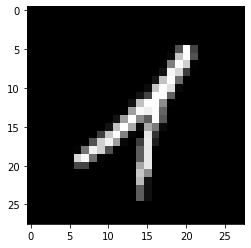

In [125]:
img,label= test_dataset[1868]
plt.imshow(img[0],cmap='gray')
print('Label:',label,',predicted:',predict_image(img,model_dropout))

## Loss and Accuracy on test dataset with Dropout

In [126]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model_dropout, test_loader)

test_loss=result['val_loss']
test_acc=result['val_acc']
print('test_loss:',test_loss)
print('test_acc:' ,test_acc)

test_loss: 0.13864083588123322
test_acc: 0.966015636920929


# Early stopping

In [127]:
def evaluate(model,val_loader):
    # evaluate model performance om validation set
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)




def fit_Early_Stopping(patience, epochs, lr , model, train_loader, val_loader,opt_func=torch.optim.SGD):
    # training the model uing gradient descent
    validation_history=[]
    training_history=[]
    optimiser=opt_func(model.parameters(), lr)
    loss_storage=[]
    
    for epoch in range(epochs):
        # Training phase
        b=[]
        for batch in train_loader:
            a= model.training_step(batch)
            #print(a.keys)
            loss=a['training_loss']
            acc=a['training_acc']
            b.append(a)
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()
        d=model.training_epoch_end(b)
        model.t_epoch_end_printformat(epoch,d)
        training_history.append(d)
        #Validation phase
        result=evaluate(model,val_loader)
        
       
                
        
        model.v_epoch_end_printformat(epoch,result)
       # early stopping code
        flag=0
        patience=patience
        validation_history.append(result)
        if len(validation_history)>patience+1:
            delta=0.01
            h=[x['val_loss'] for x in validation_history[-patience:]]
            average=sum(h)/len(h)
            best_score=min(h)
            print('best_score:',best_score)
            counter=0
            for i in h:
                #print("here")
                if i<=best_score+0.01:
                    counter=counter+1
                if counter>=patience:
                    print("cond_1")
                    flag=1
                #print("counter",counter)
            if result['val_loss']>best_score+0.01:
                print("cond_2")
                flag=1
            
            
        if flag==1:
            print("Early Stopping")
            return validation_history,training_history
        
        
        
    return validation_history,training_history



In [128]:
model_Early_Stopping=MnistModel(input_size,hidden_size=hidden_size,out_size=num_classes)
to_device(model_Early_Stopping,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=500, bias=True)
  (linear3): Linear(in_features=500, out_features=10, bias=True)
)

In [129]:
validation_history=[]
training_history=[]
patience=20

    
e,f= fit_Early_Stopping(patience,250, 0.01, model_Early_Stopping, train_loader, val_loader)

    

validation_history+=e
training_history+=f



Epoch [0], training_loss: 1.5002,training_acc:0.6783
Epoch [0], val_loss: 0.6360,val_acc:0.8424
Epoch [1], training_loss: 0.4796,training_acc:0.8729
Epoch [1], val_loss: 0.4048,val_acc:0.8847
Epoch [2], training_loss: 0.3635,training_acc:0.8981
Epoch [2], val_loss: 0.3450,val_acc:0.9011
Epoch [3], training_loss: 0.3204,training_acc:0.9087
Epoch [3], val_loss: 0.3157,val_acc:0.9094
Epoch [4], training_loss: 0.2924,training_acc:0.9165
Epoch [4], val_loss: 0.2917,val_acc:0.9176
Epoch [5], training_loss: 0.2708,training_acc:0.9231
Epoch [5], val_loss: 0.2717,val_acc:0.9225
Epoch [6], training_loss: 0.2524,training_acc:0.9273
Epoch [6], val_loss: 0.2577,val_acc:0.9267
Epoch [7], training_loss: 0.2357,training_acc:0.9324
Epoch [7], val_loss: 0.2465,val_acc:0.9287
Epoch [8], training_loss: 0.2205,training_acc:0.9372
Epoch [8], val_loss: 0.2266,val_acc:0.9346
Epoch [9], training_loss: 0.2065,training_acc:0.9417
Epoch [9], val_loss: 0.2153,val_acc:0.9375
Epoch [10], training_loss: 0.1941,traini

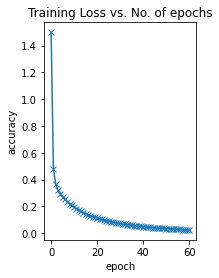

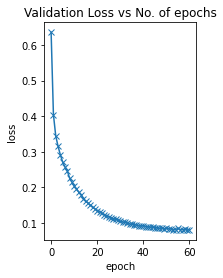

In [130]:
training_loss = [x['training_loss'] for x in training_history]
plt.subplot(1,2,1)
plt.plot(training_loss, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training Loss vs. No. of epochs');
plt.show()
validation_losses=[x['val_loss'] for x in validation_history]
plt.subplot(1,2,2)
plt.plot(validation_losses,'-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Validation Loss vs No. of epochs')
plt.show()

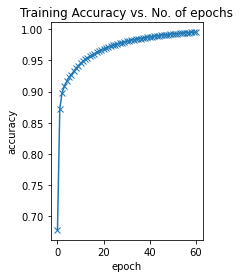

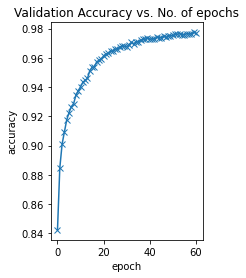

In [131]:
training_accuracies = [x['training_acc'] for x in training_history]
plt.subplot(1,2,1)
plt.plot(training_accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training Accuracy vs. No. of epochs');
plt.show()

validation_accuracies = [x['val_acc'] for x in validation_history]
plt.subplot(1,2,2)
plt.plot(validation_accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Validation Accuracy vs. No. of epochs');
plt.show()

In [132]:
def predict_image(img,model_Early_Stopping):
    xb=to_device(img.unsqueeze(0),device)
    yb=model_Early_Stopping(xb)
    _,preds=torch.max(yb,dim=1)
    return preds[0].item()

Label: 1 ,predicted: 1


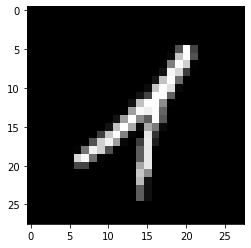

In [133]:
img,label= test_dataset[1868]
plt.imshow(img[0],cmap='gray')
print('Label:',label,',predicted:',predict_image(img,model_Early_Stopping))

In [134]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model_Early_Stopping, test_loader)

test_loss=result['val_loss']
test_acc=result['val_acc']
print('test_loss:',test_loss)
print('test_acc:' ,test_acc)

test_loss: 0.0650501623749733
test_acc: 0.9803711175918579
